In [1]:
import pandas as pd
import datetime as dt
import praw
from collections import Counter

import re

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils.extmath import randomized_svd
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jongbusherpa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


For the below, follow the directions here https://www.storybench.org/how-to-scrape-reddit-with-python/

In [2]:
PERSONAL_USE_SCRIPT_14_CHARS = 'DlOSzt8yX1sHEA'
SECRET_KEY_27_CHARS = 'akhRmZhbpUVRlPOc67CeJQSqIDY'
YOUR_APP_NAME = 'NoSleepRecommender'
YOUR_REDDIT_USER_NAME = 'josephs7'
YOUR_REDDIT_LOGIN_PASSWORD = 'Computer1'

In [3]:
reddit = praw.Reddit(client_id=PERSONAL_USE_SCRIPT_14_CHARS,
                     client_secret=SECRET_KEY_27_CHARS,
                     password=YOUR_REDDIT_LOGIN_PASSWORD,
                     user_agent=YOUR_APP_NAME,
                     username=YOUR_REDDIT_USER_NAME)

In [4]:
print(reddit.user.me())

josephs7


In [5]:
subreddit = reddit.subreddit('nosleep')

# Gettting Stories and Comments

In [6]:
stories_dict = {"story_id": [],
                "title": [],
               "author": [],
               "body": []}

In [7]:
my_subreddit = subreddit.hot(limit=1000)
for submission in my_subreddit:
    stories_dict["title"].append(submission.title)
    stories_dict["body"].append(submission.selftext)
    stories_dict["author"].append(submission.author)
    stories_dict["story_id"].append(submission.id)

In [8]:
story_df = pd.DataFrame(stories_dict)
story_df = story_df.head(500)
story_df.head()

,story_id,title,author,body
0,fmxcnp,February 2020 Voting Thread,TheCusterWolf,
1,fov3gb,**Rule Addition Announcement**,cmd102,
2,fore72,I love my husband more than anything in the wo...,inkinmycoffee,The streets glistened silently outside my wind...
3,fox9my,Working at an amusement park: my shady manager,girl_from_the_crypt,I work at an amusement park where only half of...
4,fonaxa,The Sleep Experiment (Part 3),not_neccesarily,[Part 1](https://www.reddit.com/r/nosleep/comm...


In [9]:
story_df = story_df.drop([0, 1], )
story_df.head(100)

,story_id,title,author,body
2,fore72,I love my husband more than anything in the wo...,inkinmycoffee,The streets glistened silently outside my wind...
3,fox9my,Working at an amusement park: my shady manager,girl_from_the_crypt,I work at an amusement park where only half of...
4,fonaxa,The Sleep Experiment (Part 3),not_neccesarily,[Part 1](https://www.reddit.com/r/nosleep/comm...
5,foumxy,There was something strange about my last doct...,-red-sky-,"Mama never told me who my real parents were, j..."
6,fow95x,The ice cream truck in my neighborhood sells m...,MilesCastle,[Part 1](https://www.reddit.com/r/nosleep/comm...
...,...,...,...,...
97,fo9p4j,What Man Wasn’t Meant To Know,JaybirdRS,I wasn’t there for the beginning. My story doe...
98,focujs,Man Inside of a Cat Suit.,KancerKrish,"I was walking down a empty sidewalk, with stre..."
99,fo5hnt,The room in the attic.,NinoRino123,\n\nDisclaimer: This is NOT related to the se...
100,fngdt7,The Sleep Experiment (Part 1),not_neccesarily,[Part 2](https://www.reddit.com/r/nosleep/comm...


# Implementing LSA using Gensim

In [10]:
#import modules
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel

# clean text

# remove punctuation
story_df['processed'] = story_df['body'].map(lambda x: re.sub('[,\.!?]', '', x))
story_df.head()
# make it all lower case
story_df['processed'] = story_df['processed'].map(lambda x: x.lower())
    
story_df.head(100)

,story_id,title,author,body,processed
2,fore72,I love my husband more than anything in the wo...,inkinmycoffee,The streets glistened silently outside my wind...,the streets glistened silently outside my wind...
3,fox9my,Working at an amusement park: my shady manager,girl_from_the_crypt,I work at an amusement park where only half of...,i work at an amusement park where only half of...
4,fonaxa,The Sleep Experiment (Part 3),not_neccesarily,[Part 1](https://www.reddit.com/r/nosleep/comm...,[part 1](https://wwwredditcom/r/nosleep/commen...
5,foumxy,There was something strange about my last doct...,-red-sky-,"Mama never told me who my real parents were, j...",mama never told me who my real parents were ju...
6,fow95x,The ice cream truck in my neighborhood sells m...,MilesCastle,[Part 1](https://www.reddit.com/r/nosleep/comm...,[part 1](https://wwwredditcom/r/nosleep/commen...
...,...,...,...,...,...
97,fo9p4j,What Man Wasn’t Meant To Know,JaybirdRS,I wasn’t there for the beginning. My story doe...,i wasn’t there for the beginning my story does...
98,focujs,Man Inside of a Cat Suit.,KancerKrish,"I was walking down a empty sidewalk, with stre...",i was walking down a empty sidewalk with stree...
99,fo5hnt,The room in the attic.,NinoRino123,\n\nDisclaimer: This is NOT related to the se...,\n\ndisclaimer: this is not related to the se...
100,fngdt7,The Sleep Experiment (Part 1),not_neccesarily,[Part 2](https://www.reddit.com/r/nosleep/comm...,[part 2](https://wwwredditcom/r/nosleep/commen...


In [11]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

In [12]:
# LSA Model
number_of_topics=20
words=10
stories = story_df['body'].values.astype('U')
clean_text=preprocess_data(stories)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)
model.print_topics(2)

[(0, '0.234*"look" + 0.234*"like" + 0.189*"back" + 0.175*"one" + 0.171*"could" + 0.157*"go" + 0.153*"time" + 0.150*"would" + 0.149*"said" + 0.148*"get"'), (1, '0.919*"x200b" + 0.109*"look" + -0.103*"would" + 0.093*"scott" + 0.058*"oliv" + -0.053*"jame" + -0.053*"could" + -0.052*"ricki" + 0.049*"grandma" + -0.049*"eye"'), (2, '0.606*"jame" + 0.449*"ricki" + -0.173*"look" + 0.168*"mother" + 0.158*"said" + 0.121*"us" + 0.121*"ask" + 0.106*"dad" + 0.104*"mom" + -0.099*"one"'), (3, '-0.285*"hand" + -0.261*"_" + -0.258*"said" + 0.164*"time" + -0.155*"eye" + -0.151*"back" + -0.145*"bab" + -0.141*"lonni" + -0.130*"look" + 0.128*"one"'), (4, '-0.357*"look" + -0.333*"said" + 0.228*"would" + 0.195*"linda" + 0.186*"x200b" + 0.174*"bodi" + -0.171*"ask" + -0.135*"us" + 0.132*"like" + 0.120*"felt"'), (5, '0.598*"linda" + 0.190*"mr" + 0.184*"brook" + 0.169*"abigail" + 0.163*"said" + 0.156*"class" + 0.147*"thumper" + 0.118*"fuck" + -0.116*"jame" + -0.112*"bodi"'), (6, '0.442*"door" + -0.269*"said" + -0

[(0,
  '0.234*"look" + 0.234*"like" + 0.189*"back" + 0.175*"one" + 0.171*"could" + 0.157*"go" + 0.153*"time" + 0.150*"would" + 0.149*"said" + 0.148*"get"'),
 (1,
  '0.919*"x200b" + 0.109*"look" + -0.103*"would" + 0.093*"scott" + 0.058*"oliv" + -0.053*"jame" + -0.053*"could" + -0.052*"ricki" + 0.049*"grandma" + -0.049*"eye"')]

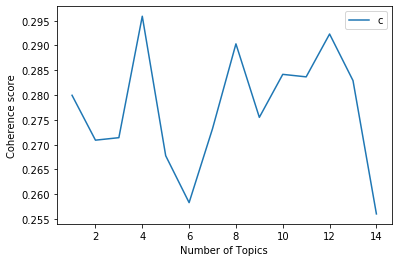

In [13]:
start,stop,step=1,15,1
plot_graph(clean_text,start,stop,step)